In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import Bio.PDB.Polypeptide as pp
from os.path import join
import os
from matplotlib import cm

In [2]:
AA = list(pp.aa1)

In [3]:
DATA = 'data/'

In [4]:
proteins = ['1be9', '1d5r', '1nd4', '3dqw', '4bz3']
protein_names = ['PSD95', 'PTEN', 'APH(3\')II', 'Src CD', 'VIM-2']

In [5]:
data_path = join(DATA, 'structure')
thresholds = [round(i, 1) for i in np.linspace(3, 10, 71)]
sample_thresholds = [round(i, 1) for i in np.linspace(3, 10, 8)]
measures = ['nodes', 'edges', 'weight', 'distance']

In [6]:
functional_data = dict()
for protein in proteins:
    csv_file = join(DATA, f'functional_{protein}.csv')
    functional_data[protein] = pd.read_csv(csv_file, index_col=0, header=0)

In [7]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

In [8]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [9]:
def ReadNetworkCSV(protein, threshold, measure):
    """Return DataFrame from corresponding CSV. If protein has multiple identical chains, return average value for 
    each position amongst all chains."""
    file = os.path.join(join(DATA, 'structure'), f"{protein}/{protein}_{threshold}_{measure}.csv")
    network_df = pd.read_csv(file, header=0)
    network_df.index = AA
    # Get chains from columns
    column_names = list(network_df.columns)
    chains = list(set([position[1] for position in column_names]))
    # Get positions without chain distinction from functional files
    positions = list(functional_data[protein].columns)
    average = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)
    # Save data for position over chains in list, write average into df
    for position in positions:
        for aa in AA:
            values = []
            for chain in chains:
                check = position[0]+chain+position[1:]
                if check in network_df.columns:
                    values.append(network_df.at[aa, check])
            if values:
                average_value = sum(values)/len(values)
                average.at[aa, position] = average_value
    return average

In [10]:
def Standardize(protein, threshold, measure):
    """Return standardized values from network data. Make 0's into NaN. """
    network_df = ReadNetworkCSV(protein, threshold, measure)
    for position in network_df.columns:
        for aa in network_df.index:
            if position[0] == aa:
                network_df.at[aa, position] = np.nan
    data_array = network_df.to_numpy()
    data_mean = np.nanmean(network_df, dtype=np.float64)
    data_std = np.nanstd(network_df, dtype=np.float64)
    network_df = network_df.apply(lambda x:(x-data_mean)/data_std)
    return network_df 

In [11]:
def GetPercentage(percentage, which, data, return_score=False):
    """Return set with top or bottom percentage of positions according to functional data. 
    Parameters:
        percentage (float): between 0 and 1, percentage of positions that we want.
        which (str): 'highest', 'lowest'
        data (dataframe): functional data to consider mean of
        return_score (bool): If True, return list of tuples with mean value and position
    Returns:
        Set of positions.
    """
    functional_mean = data.mean()
    positions = list(data.columns)
    pairs = [(functional_mean[pos], pos) for pos in positions] 
    pairs.sort(key = lambda x:x[0]) 
    if which == 'highest': 
        pairs.reverse() 
    n = int(len(positions)*percentage)
    if return_score:
        return [pair for pair in pairs[:n]]
    else:
        return set([pair[1] for pair in pairs[:n]])

In [12]:
def GetNetworkExtremes(protein, mincount, measure_cutoffs, thresh=9.0):
    """ Return set with positions that pass measure sd cutoffs for at least mincount measures. """
    network_extremes_list = []
    for i,measure in enumerate(measures): 
        threshold = 3.8 if measure == 'distance' else thresh
        network_df = Standardize(protein, threshold, measure)
        if measure_cutoffs[i] > 0:
            extremes = network_df.columns[(network_df > measure_cutoffs[i]).any()].tolist()
        else:
            extremes = network_df.columns[(network_df < measure_cutoffs[i]).any()].tolist()
        network_extremes_list.extend(extremes)

    counter = Counter(network_extremes_list)
    positions = list(set(network_extremes_list))
    return set([pos for pos in positions if counter[pos] >= mincount])

In [13]:
def ToPercentage(a,b):
    """Return percentage form of a/b, if b != 0. If given set or list, use len of. 
    If string, return formatted percentage, else float."""
    x = a if type(a) == int or type(a) == float else len(a)
    y = b if type(b) == int or type(b) == float else len(b)
    
    if y == 0:
        return np.nan
    else:
        return round(100*x/y,1)

### Accuracy and Coverage vs Position Percentages

Compare Accuracy scores with functional percentage, leaving parameters fixed at [1,1,1,1] and mincount of 2; 
    and Coverage scores with prediction percentage, leaving functional percentage fixed at 40%, mincount fixed at 2,
    and varying the functional cutoffs from 1 to 2. Considering loss of function predictions. 

In [15]:
# Save data, each will have 5 lists with data for each protein 
data_ac = {"accuracy_fsp":[], "coverage_fsp":[], "accuracy_pred":[], "coverage_pred":[]}

In [16]:
# Accuracy and functional percentage
percentage_range = [round(i,2) for i in np.linspace(0.3, 0.7, 41)] # diff funct percentages to test
for i, protein in enumerate(proteins):
    accuracy = []
    network_extremes = GetNetworkExtremes(protein, 2, measure_cutoffs=[1,1,1,1])
    for percentage in percentage_range:
        funct_extremes = GetPercentage(percentage, 'lowest', functional_data[protein])
        how_many = funct_extremes.intersection(network_extremes)
        accuracy.append(ToPercentage(how_many, network_extremes))
    data_ac["accuracy_fsp"].append(accuracy)

In [18]:
# Coverage and functional percentage
for i, protein in enumerate(proteins):
    coverage = []
    network_extremes = GetNetworkExtremes(protein, 2, measure_cutoffs=[1,1,1,1])
    for percentage in percentage_range:
        funct_extremes = GetPercentage(percentage, 'lowest', functional_data[protein])
        how_many = funct_extremes.intersection(network_extremes)
        coverage.append(ToPercentage(how_many, funct_extremes))
    data_ac["coverage_fsp"].append(coverage)

In [20]:
# Accuracy and prediction percentage    
cutoffs = [round(i,2) for i in np.linspace(1,2,81)] # cutoffs to use to get diff prediction percentages
for i, protein in enumerate(proteins):
    accuracy = []
    n = len(functional_data[protein].columns)
    prediction_percentage = []
    funct_extremes = GetPercentage(0.4, 'lowest', functional_data[protein])
    for cutoff in cutoffs:
        network_extremes = GetNetworkExtremes(protein, 2, measure_cutoffs=[cutoff]*4)
        how_many = funct_extremes.intersection(network_extremes)
        prediction_percentage.append(ToPercentage(network_extremes, n))
        accuracy.append(ToPercentage(how_many, network_extremes))
    data_ac["accuracy_pred"].append(accuracy)
    

In [21]:
# Coverage and prediction percentage
for i, protein in enumerate(proteins):
    coverage = []
    n = len(functional_data[protein].columns)
    prediction_percentage = []
    funct_extremes = GetPercentage(0.4, 'lowest', functional_data[protein])
    for cutoff in cutoffs:
        network_extremes = GetNetworkExtremes(protein, 2, measure_cutoffs=[cutoff]*4)
        how_many = funct_extremes.intersection(network_extremes)
        prediction_percentage.append(ToPercentage(network_extremes, n))
        coverage.append(ToPercentage(how_many, funct_extremes))
    data_ac["coverage_pred"].append(coverage)

In [ ]:
percentage_range =[round(i,2) for i in np.linspace(0.3, 0.7, 41)]

In [52]:
dfs = []
for head in data_ac.keys():
    df_ac = pd.DataFrame(data_ac[head])
    df_ac = pd.melt(df_ac, var_name="percentage")
    df_ac["type"] = head.replace("_", " ")
    col_prot = protein_names * (df_ac.shape[0]//5)
    df_ac["protein"] = col_prot
    dfs.append(df_ac)
df = pd.concat(dfs)

In [53]:
df.head()

,percentage,value,type,protein
0,0,43.5,accuracy fsp,PSD95
1,0,53.6,accuracy fsp,PTEN
2,0,51.2,accuracy fsp,APH(3')II
3,0,37.7,accuracy fsp,Src CD
4,0,48.9,accuracy fsp,VIM-2


/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


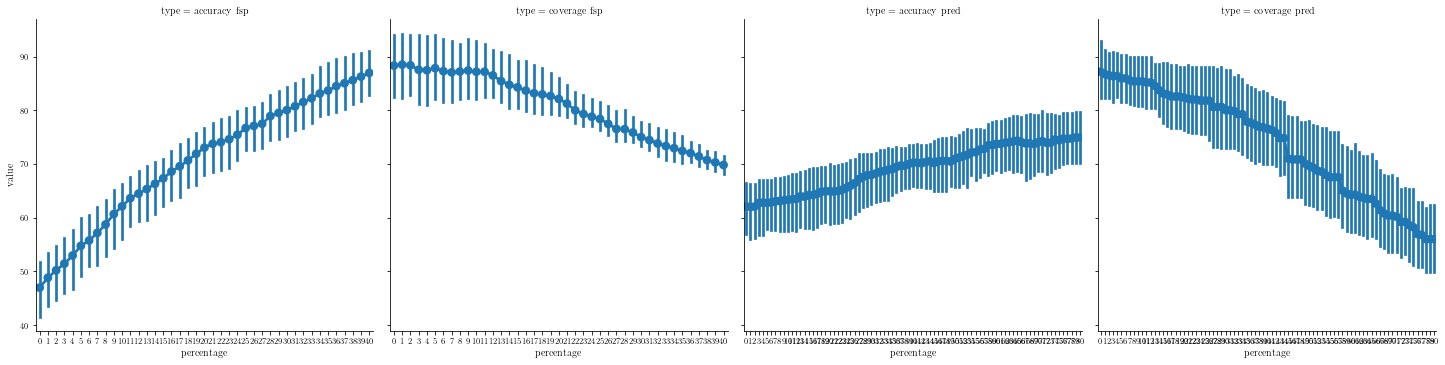

In [56]:
g = sns.catplot(data=df, col="type", kind="point", x="percentage", y="value", sharex=False)

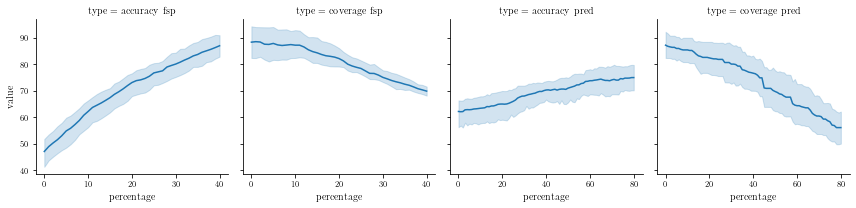

In [59]:
g2 = sns.FacetGrid(data=df, col="type", sharex=False)
g2.map(sns.lineplot, "percentage", "value")

### Predictions for single measure

In [14]:
def NetworkExtremesOneMeasure(protein, measure, cutoff, threshold):
    """ Return set with positions that have mutations that pass measure cutoff. """
    network_df = Standardize(protein, threshold, measure)
    extremes = network_df.columns[(network_df > cutoff).any()].tolist()
    return set(extremes)

In [15]:
def PredictionsOneMeasure(measure, cutoff, save=False):
    """Loss of function predictions based only on one measure, to find best threshold per measure."""
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25,5), sharex=True, sharey=True)
    
    fig.add_subplot(111, frameon=False)
    plt.tight_layout()
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.ylabel('Percentage (%)')
    plt.xlabel('Thresholds')
    
    for i, protein in enumerate(proteins):
        predictions, how_many = dict(), dict()
        funct_extremes = GetPercentage(0.4, 'lowest', functional_data[protein])

        for threshold in thresholds:
            # positions predicted
            predictions[threshold] = NetworkExtremesOneMeasure(protein, measure, cutoff, threshold)
            # positions in intersection between predictions and funct_extremes 
            how_many[threshold] = predictions[threshold].intersection(funct_extremes)
            
        accuracy = [ToPercentage(how_many[threshold], predictions[threshold]) for threshold in thresholds] 
        coverage = [ToPercentage(how_many[threshold], funct_extremes) for threshold in thresholds] 
        
        ax = axes[i]
        ax.set_xlim(3,10)
        ax.set_ylim(0,100)
        ax.plot(thresholds, accuracy, color='darkgreen', marker='o', markeredgewidth=0.0, linewidth=0,
                 label='Accuracy')
        ax.plot(thresholds, coverage, color='darkblue', marker='o', markeredgewidth=0.0, linewidth=0,
                 label='Coverage')
        ax.set_title(protein_names[i])
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels)

    if save:
        cutoff1 = 1 if cutoff == 1 else 15
        fig.savefig(os.path.join(figures_path,f'{measure}{cutoff1}'))
    return fig

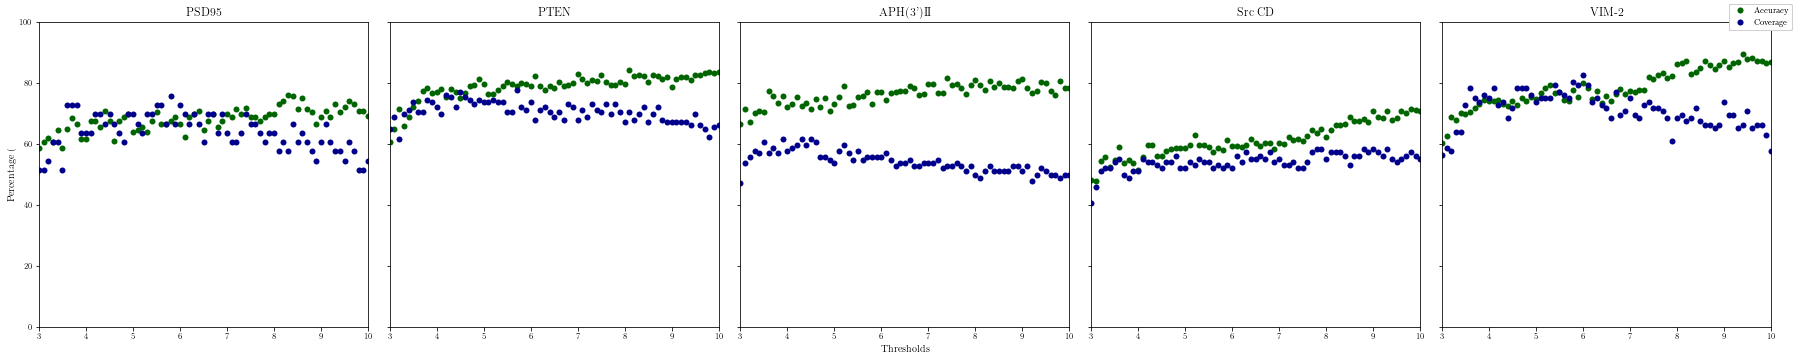

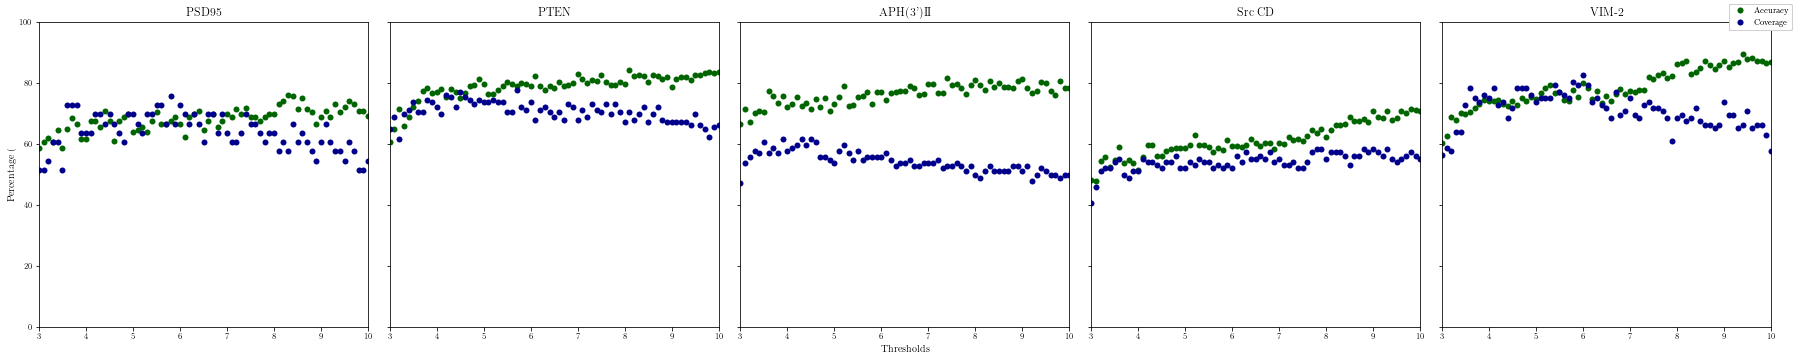

In [16]:
PredictionsOneMeasure('nodes', 1.5)

In [ ]:
for i, protein in enumerate(proteins):
    predictions, how_many = dict(), dict()
    funct_extremes = GetPercentage(0.4, 'lowest', functional_data[protein])

    for threshold in thresholds:
        # positions predicted
        predictions[threshold] = NetworkExtremesOneMeasure(protein, measure, cutoff, threshold)
        # positions in intersection between predictions and funct_extremes 
        how_many[threshold] = predictions[threshold].intersection(funct_extremes)

    accuracy = [ToPercentage(how_many[threshold], predictions[threshold]) for threshold in thresholds] 
    coverage = [ToPercentage(how_many[threshold], funct_extremes) for threshold in thresholds] 
